<a href="https://colab.research.google.com/github/alfanadhya/acne-detection-with-glcm-and-gabor/blob/main/get_gabor_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# LIBRARIES

# for feature normalization
from sklearn import preprocessing

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# to get file directory
import glob
from natsort import natsorted
from os.path import join

# to save scaler
import joblib

# to split training and test data
from sklearn.model_selection import train_test_split

# to create gmm
from sklearn.mixture import GaussianMixture

In [ ]:
# DATA
acne_blocks_path = '/content/drive/MyDrive/DatasetTA_Playground/acne_blocks/'
no_acne_blocks_path = '/content/drive/MyDrive/DatasetTA_Playground/skin_blocks/'

acne_blocks_dir = natsorted(glob.glob(join(acne_blocks_path, '*.jpg')))
no_acne_blocks_dir = natsorted(glob.glob(join(no_acne_blocks_path, '*.jpg')))

In [ ]:
acne_blocks = []

for block in acne_blocks_dir:
  acne_img = cv2.imread(block)
  acne_blocks.append(cv2.cvtColor(acne_img, cv2.COLOR_BGR2GRAY))

no_acne_blocks = []

for block in no_acne_blocks_dir:
  no_acne_img = cv2.imread(block)
  no_acne_blocks.append(cv2.cvtColor(no_acne_img, cv2.COLOR_BGR2GRAY))

In [ ]:
thetas = (0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, 2*np.pi/3, 3*np.pi/4, 5*np.pi/6)
#thetas = (0, np.pi/4, np.pi/2, 3*np.pi/4)
k_size = (3,3)
sigma = 1
#sigmas = (1,2)
psi = np.pi/2
lambd = 0.8
gamma = 0
kernels = []
c = 0
for theta in thetas:
  # for sigma in sigmas:
    kernel = cv2.getGaborKernel(ksize=k_size, sigma=sigma, theta=theta, lambd=lambd, gamma=gamma, psi=psi)
    kernels.append(kernel)
    c = c+1

In [ ]:
no_acne_data = np.zeros((len(no_acne_blocks), (len(kernels)*2)+1))
acne_data = np.zeros((len(acne_blocks), (len(kernels)*2)+1))
feats_mean = np.zeros(len(kernels), dtype=np.double)
feats_var = np.zeros(len(kernels), dtype=np.double)

for counter, block in enumerate(no_acne_blocks):
  for k, kernel in enumerate(kernels):
    res = cv2.filter2D(block, ddepth=0, kernel=kernel)
    feats_mean[k] = res.mean()
    feats_var[k] = res.var()
  no_acne_data[counter, :no_acne_data.shape[1]-1] = np.concatenate((feats_mean, feats_var))
  no_acne_data[counter, -1] = 0

for counter, block in enumerate(acne_blocks):
  for k, kernel in enumerate(kernels):
    res = cv2.filter2D(block, ddepth=0, kernel=kernel)
    feats_mean[k] = res.mean()
    feats_var[k] = res.var()
  acne_data[counter, :acne_data.shape[1]-1] = np.concatenate((feats_mean, feats_var))
  acne_data[counter, -1] = 1

In [ ]:
no_acne_df = pd.DataFrame(no_acne_data)
acne_df = pd.DataFrame(acne_data)

In [ ]:
# Create scaler
scaler = preprocessing.MinMaxScaler()

# Normalization
scaled_data = scaler.fit_transform(np.concatenate((no_acne_data[:,:-1],acne_data[:,:-1]), axis=0))
#scaled_acne_data = scaler.fit_transform(acne_data[:,:-1])

In [ ]:
# Save normalization scaler
joblib.dump(scaler, '/content/drive/MyDrive/DatasetTA_Playground/experiments/knn_models/scaler_knn_gabor.pkl')

['/content/drive/MyDrive/DatasetTA_Playground/experiments/knn_models/scaler_knn_gabor.pkl']

In [ ]:
scaled_data.shape

(1778, 16)

## Train GMM Classifier

In [ ]:
X_train_no_acne, X_test_no_acne, y_train_no_acne, y_test_no_acne = train_test_split(scaled_data[:908], no_acne_data[:,-1], test_size=0.2, random_state = 42)
X_train_acne, X_test_acne, y_train_acne, y_test_acne = train_test_split(scaled_data[908:], acne_data[:,-1], test_size=0.2, random_state = 42)

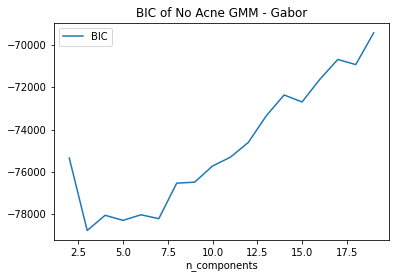

In [ ]:
n_components = np.arange(2, 20)
no_acne_gmm = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_train_no_acne) for n in n_components]
plt.plot(n_components, [m.bic(scaled_data[:908]) for m in no_acne_gmm], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('BIC of No Acne GMM - Gabor')
plt.show()

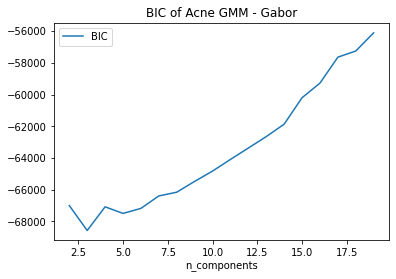

In [ ]:
n_components = np.arange(2, 20)
acne_gmm = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_train_acne) for n in n_components]
plt.plot(n_components, [m.bic(scaled_data[908:]) for m in acne_gmm], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('BIC of Acne GMM - Gabor')
plt.show()

In [ ]:
best_no_acne_gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0).fit(X_train_no_acne)
best_acne_gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0).fit(X_train_acne)

In [ ]:
scores = []
test_concat = np.concatenate((X_test_acne, X_test_no_acne), axis=0)
for i in test_concat:
  proc_image = np.reshape(i, (1, -1))
  no_acne_score = best_no_acne_gmm.score_samples(proc_image)
  acne_score = best_acne_gmm.score_samples(proc_image)
  res = acne_score > no_acne_score
  
  scores.append(res*1)

In [ ]:
sc = np.concatenate(scores)
sc_gt = np.concatenate((y_test_acne, y_test_no_acne), axis=0)

test_acc = np.mean(sc.ravel() == sc_gt.ravel()) * 100
test_acc

67.13483146067416

In [ ]:
# save to file
'''
gmm_name = '/content/drive/MyDrive/DatasetTA_Playground/experiments/gmm_models/gmm_gabor_no_acne'

np.save(gmm_name + '_weights', best_no_acne_gmm.weights_, allow_pickle=False)
np.save(gmm_name + '_means', best_no_acne_gmm.means_, allow_pickle=False)
np.save(gmm_name + '_covariances', best_no_acne_gmm.covariances_, allow_pickle=False)
'''

##Train KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score

In [ ]:
# X_result = np.concatenate((scaled_no_acne_data, scaled_acne_data), axis=0)
y_result = np.concatenate((no_acne_data[:,-1], acne_data[:,-1]), axis=0)
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y_result, test_size=0.2, random_state = 42)

13 0.7191011235955056


Text(0.5, 1.0, 'KNN Testing Accuracy')

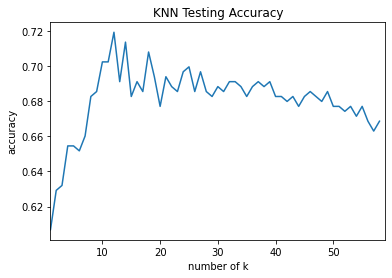

In [ ]:
# try K and record testing accuracy
k_range = range(1, 60)

knn_scores = []
knn_models = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_models.append(knn)

    y_pred = knn.predict(X_test)
    knn_scores.append(accuracy_score(y_test, y_pred))

best_k = knn_scores.index(max(knn_scores))
print(best_k+1, max(knn_scores))

plt.plot(knn_scores)
plt.xlabel('number of k')
plt.ylabel('accuracy')
plt.xlim([1, 59])
plt.title('KNN Testing Accuracy')

In [ ]:
joblib.dump(knn_models[best_k], '/content/drive/MyDrive/DatasetTA_Playground/experiments/knn_models/knn_gabor.pkl')

['/content/drive/MyDrive/DatasetTA_Playground/experiments/knn_models/knn_gabor.pkl']